In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from acquire_zillow import get_connection
from acquire_zillow import get_zillow_data
from acquire_mall import get_mall_data
from prepare_zillow import prepare_zillow_db
from prepare_zillow import get_numeric_columns
from prepare_zillow import create_clusters

%matplotlib inline
from matplotlib import pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

import scipy.stats as stats
from scipy.stats import pearsonr

import graphviz
from graphviz import Graph

import env
seed = 123

Either use get_zillow_data to connect to sql and load directly to a dataframe (and the write to working directory csv),    or read from csv into dataframe

In [2]:
# df = get_zillow_data()
# df.to_csv('zillow.csv', index=False)

In [3]:
df = pd.read_csv('zillow.csv')

In [4]:
df = prepare_zillow_db(df)

In [5]:
df['error_bin'] = pd.qcut(df.logerror, 4, labels=[ 'q1', 'q2', 'q3', 'q4'])
# df['error_bin'] = pd.qcut(df.logerror, 4, labels=False)

In [6]:
features_for_pairplot = ['logerror','calculatedfinishedsquarefeet','lotsizesquarefeet','regionidzip','taxvaluedollarcnt', 'yearbuilt', 'landtaxvaluedollarcnt']
# features_for_pairplot = ['logerror','calculatedfinishedsquarefeet','lotsizesquarefeet']
                         

In [7]:
# g = sns.pairplot(df, vars=features_for_pairplot, hue='error_bin')

In [8]:
df.describe()

,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidzip,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,censustractandblock
count,1.487010e+05,148701.000000,148701.000000,148701.000000,148701.000000,148701.000000,148701.000000,1.487010e+05,1.487010e+05,1.487010e+05,1.487010e+05,148701.000000,148701.000000,1.487010e+05,1.487010e+05,148701.000000,1.487010e+05,1.487010e+05
mean,1.303273e+07,0.013465,2.273475,3.021506,2.273115,1739.031836,1736.652928,3.400195e+07,-1.181902e+08,2.675867e+04,6.049780e+07,32930.517091,96597.427677,1.782543e+05,4.526594e+05,2015.463474,2.744051e+05,6.034969e+13
std,2.394578e+06,0.155584,0.882202,0.980987,0.882620,830.407749,832.866527,2.705146e+05,3.642255e+05,1.181359e+05,2.065378e+05,46036.409841,3874.929584,1.600801e+05,3.973012e+05,0.498666,2.835178e+05,3.217574e+12
min,1.071174e+07,-4.655420,1.000000,1.000000,0.000000,500.000000,0.000000,3.333953e+07,-1.194754e+08,0.000000e+00,6.037101e+07,0.000000,0.000000,2.500000e+04,3.615200e+04,2015.000000,1.004000e+04,0.000000e+00
25%,1.153996e+07,-0.023713,2.000000,2.000000,2.000000,1183.000000,1182.000000,3.379877e+07,-1.184134e+08,5.065000e+03,6.037401e+07,12447.000000,96213.000000,8.546400e+04,2.111660e+05,2015.000000,8.901000e+04,6.037401e+13
50%,1.262121e+07,0.006000,2.000000,3.000000,2.000000,1526.000000,1526.000000,3.401374e+07,-1.181570e+08,6.904000e+03,6.037651e+07,25218.000000,96414.000000,1.350000e+05,3.551630e+05,2015.000000,2.030500e+05,6.037651e+13
75%,1.428938e+07,0.037300,3.000000,4.000000,3.000000,2064.000000,2063.000000,3.417640e+07,-1.179072e+08,1.075800e+04,6.059052e+07,45398.000000,96989.000000,2.130080e+05,5.556040e+05,2016.000000,3.589490e+05,6.059052e+13
max,1.629608e+08,4.737000,7.000000,7.000000,7.000000,7985.000000,7985.000000,3.481877e+07,-1.175546e+08,6.971010e+06,6.111009e+07,396556.000000,399675.000000,1.976957e+06,4.403314e+06,2016.000000,2.500000e+06,4.830301e+14


In [9]:
# plt.figure(figsize=(16,16))
# sns.heatmap(df.corr(), cmap='icefire', annot=True)

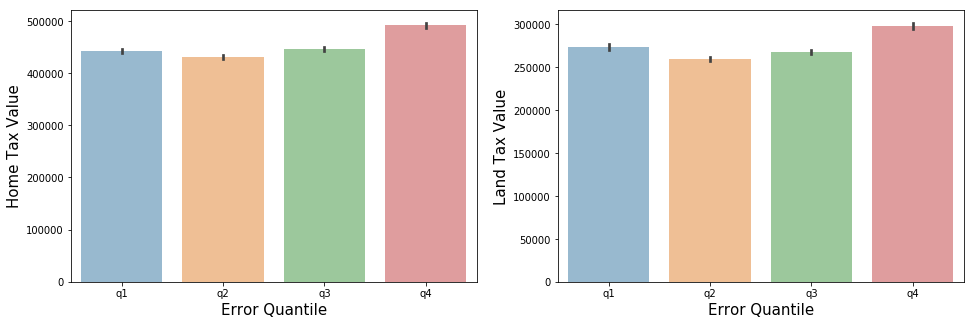

In [10]:
features =  ['taxvaluedollarcnt','landtaxvaluedollarcnt']

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

log_rate = df.logerror.mean()

for i, feature in enumerate(features):
    feature_name = ['Home Tax Value','Land Tax Value']
    sns.barplot('error_bin', feature, data=df, ax=ax[i], alpha=.5)
    ax[i].set_xlabel('Error Quantile', fontsize=15)
    ax[i].set_ylabel(feature_name[i], fontsize=15)

In [11]:
Features2cluster = ['latitude','longitude','logerror','bathroomcnt']
#  try 1-10 clusters
inertias = []
for thiscluster in range(1, 11):
    df, cluster_inertia, cluster_labels = create_clusters(df,Features2cluster,thiscluster,'cluster_target')
    inertias.append(cluster_inertia)
    
kmeans_perf = pd.DataFrame(list(zip(range(1, 11), inertias)), columns=['n_clusters', 'ssd'])

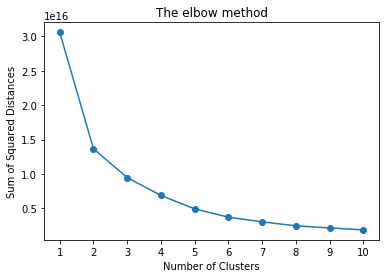

In [12]:
plt.scatter(kmeans_perf.n_clusters, kmeans_perf.ssd)
plt.plot(kmeans_perf.n_clusters, kmeans_perf.ssd)
plt.xticks(range(1, 11))
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('The elbow method')
plt.show()

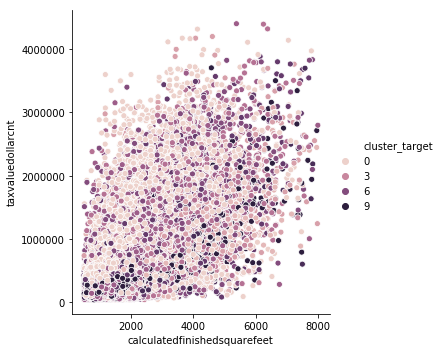

In [13]:
sns.relplot(data=df, x='calculatedfinishedsquarefeet', y='taxvaluedollarcnt', hue='cluster_target')

<IPython.core.display.Javascript object>


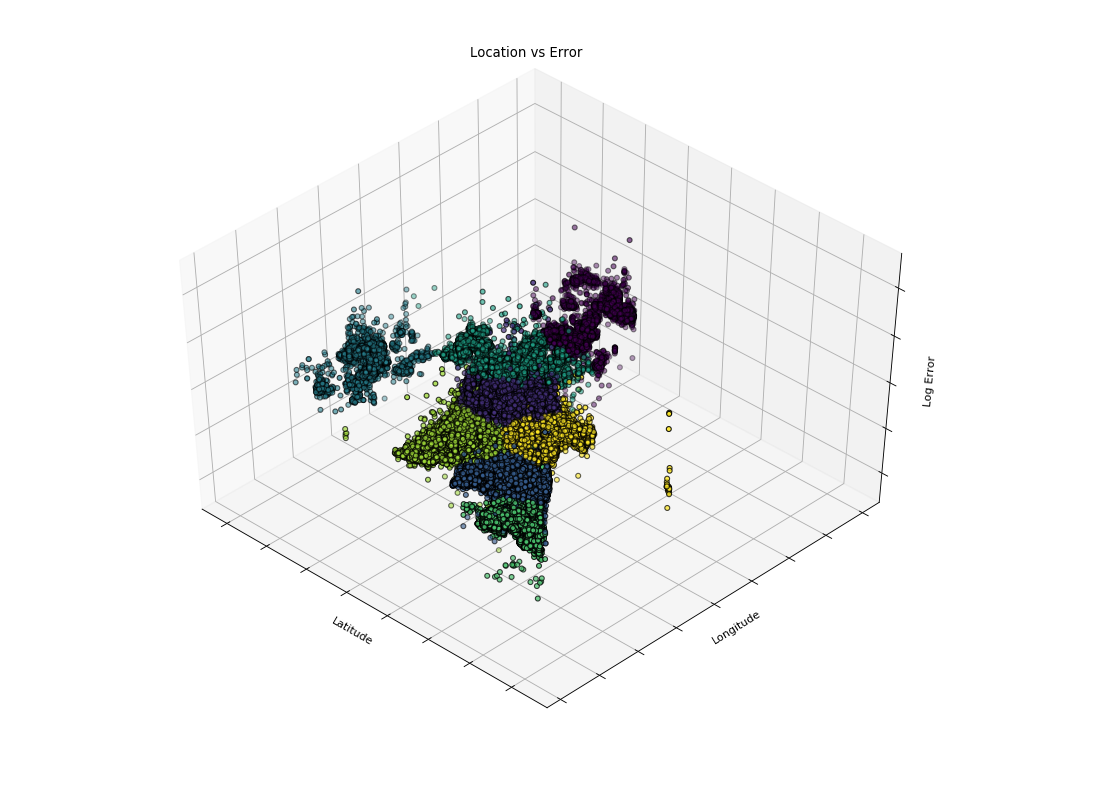

In [19]:
%matplotlib notebook
Features2cluster = ['latitude','longitude','logerror','bathroomcnt']
fig = plt.figure(1, figsize=(14, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
df, cluster_inertia, cluster_labels = create_clusters(df,Features2cluster,8,'cluster_target')
# plot the points
ax.scatter(df.latitude, df.longitude, df.logerror,
               c=cluster_labels.astype(np.float), edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Log Error')

ax.set_title('Location vs Error')
ax.dist = 12

